# Fraud Detector Project

In [ ]:
!pip install squarify

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import squarify

from sklearn.utils import resample
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_curve, auc
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier


import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'svg'
sns.set(style='whitegrid')

# <a id='first'></a> Loading Data

In [ ]:
DATAPATH = 'Insurance claims data.csv'
df = pd.read_csv(DATAPATH)
df.head()

,policy_id,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status
0,POL045360,9.3,1.2,41,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
1,POL016745,8.2,1.8,35,C2,27003,C1,M9,Diesel,200Nm@1750rpm,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,4,0
2,POL007194,9.5,0.2,44,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
3,POL018146,5.2,0.4,44,C10,73430,A,M1,CNG,60Nm@3500rpm,...,No,No,No,Yes,No,No,No,Yes,0,0
4,POL049011,10.1,1.0,56,C13,5410,B2,M5,Diesel,200Nm@3000rpm,...,No,Yes,Yes,Yes,No,No,Yes,Yes,5,0


In [ ]:
# Retrieve the column names
column_names = df.columns
print(column_names)


Index(['policy_id', 'subscription_length', 'vehicle_age', 'customer_age',
       'region_code', 'region_density', 'segment', 'model', 'fuel_type',
       'max_torque', 'max_power', 'engine_type', 'airbags', 'is_esc',
       'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
       'is_parking_camera', 'rear_brakes_type', 'displacement', 'cylinder',
       'transmission_type', 'steering_type', 'turning_radius', 'length',
       'width', 'gross_weight', 'is_front_fog_lights', 'is_rear_window_wiper',
       'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist',
       'is_power_door_locks', 'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert', 'ncap_rating', 'claim_status'],
      dtype='object')


In [ ]:

shape = df.shape
print(shape)

(58592, 41)


בדקנו את סוגי הFEATURES

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   subscription_length               58592 non-null  float64
 2   vehicle_age                       58592 non-null  float64
 3   customer_age                      58592 non-null  int64  
 4   region_code                       58592 non-null  object 
 5   region_density                    58592 non-null  int64  
 6   segment                           58592 non-null  object 
 7   model                             58592 non-null  object 
 8   fuel_type                         58592 non-null  object 
 9   max_torque                        58592 non-null  object 
 10  max_power                         58592 non-null  object 
 11  engine_type                       58592 non-null  object 
 12  airb

In [ ]:
# Dropping the 'policy_id' column
df.drop(columns='policy_id', axis=1, inplace=True)


# <a id='third'></a> Exploratory Data Analysis


Top Chi-Square scores for categorical features:

             Feature  Chi2 Score   p-value
4         max_torque   21.968526  0.000003
0        region_code   18.482415  0.000017
5          max_power    6.673275  0.009787
2              model    5.512647  0.018879
9      steering_type    4.424854  0.035419
3          fuel_type    3.761867  0.052434
1            segment    3.005149  0.083000
6        engine_type    0.066023  0.797218
8  transmission_type    0.008291  0.927448
7   rear_brakes_type    0.006927  0.933670


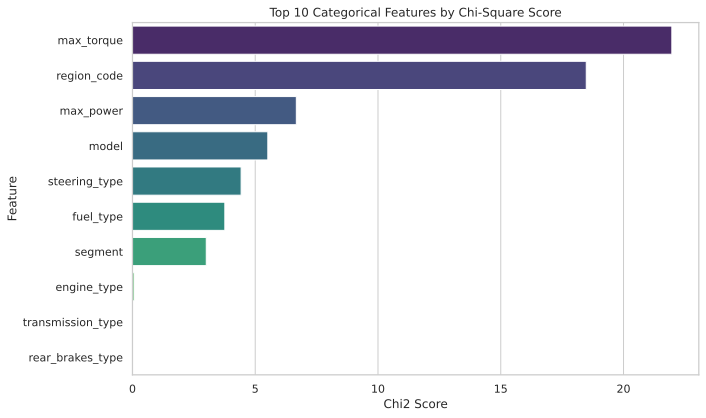


Highly correlated feature pairs (|corr| > 0.85):
                  feature_1                         feature_2  correlation
748     is_power_door_locks                            is_ecw     1.000000
755      is_central_locking                            is_ecw     1.000000
702    is_rear_window_wiper             is_rear_window_washer     1.000000
744     is_power_door_locks                is_central_locking     1.000000
390                 airbags             is_rear_window_washer     0.997013
389                 airbags              is_rear_window_wiper     0.997013
696     is_front_fog_lights  is_driver_seat_height_adjustable     0.987346
553            displacement                            length     0.961655
434  is_adjustable_steering                          cylinder     0.957287
441  is_adjustable_steering               is_front_fog_lights     0.945062

High-risk regions (claim rate > 10%):
['C18']


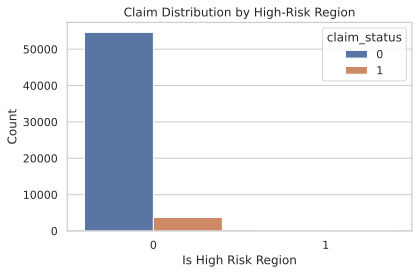

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

# Read the insurance claims dataset from CSV
df = pd.read_csv("Insurance claims data.csv")

# Identify and convert Yes/No columns to binary numeric format
binary_cols = [col for col in df.columns if set(df[col].dropna().unique()) <= {"Yes", "No"}]
df[binary_cols] = df[binary_cols].replace({"Yes": 1, "No": 0})

# Remove policy ID if present to avoid leakage or redundancy
if "policy_id" in df.columns:
    df.drop(columns=["policy_id"], inplace=True)

# Transform categorical columns using label encoding
df_encoded = df.copy()
label_encoders = {}
cat_cols = df.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le

# Isolate target variable and categorical feature matrix
y = df_encoded['claim_status']
X_cat = df_encoded[cat_cols]

# Compute Chi-square scores and p-values for each categorical feature
chi_scores, p_values = chi2(X_cat, y)
chi_df = pd.DataFrame({
    'Feature': cat_cols,
    'Chi2 Score': chi_scores,
    'p-value': p_values
}).sort_values(by='Chi2 Score', ascending=False)

# Output the top 10 features with the highest Chi-square values
print("\nTop Chi-Square scores for categorical features:\n")
print(chi_df.head(10))

# Visualize the Chi-square scores of the top 10 categorical variables
plt.figure(figsize=(10, 6))
sns.barplot(data=chi_df.head(10), x='Chi2 Score', y='Feature', palette="viridis")
plt.title("Top 10 Categorical Features by Chi-Square Score")
plt.tight_layout()
plt.show()

# Generate correlation matrix and find strong correlations among numeric features
corr_matrix = df_encoded.corr(numeric_only=True)
upper = corr_matrix.where(~np.tril(np.ones(corr_matrix.shape)).astype(bool))
high_corr_pairs = (
    upper.stack()
    .reset_index()
    .rename(columns={0: "correlation", "level_0": "feature_1", "level_1": "feature_2"})
)
redundant = high_corr_pairs[high_corr_pairs["correlation"].abs() > 0.85]

print("\nHighly correlated feature pairs (|corr| > 0.85):")
print(redundant.sort_values(by="correlation", ascending=False).head(10))

# Identify and mark regions with elevated claim frequency
region_claim_rate = df.groupby('region_code')['claim_status'].mean()
threshold = 0.10
high_risk_regions = region_claim_rate[region_claim_rate > threshold].index.tolist()
df['is_high_risk_region'] = df['region_code'].apply(lambda x: 1 if x in high_risk_regions else 0)

print("\nHigh-risk regions (claim rate > 10%):")
print(high_risk_regions)

# Visualize how claim distribution varies with high-risk region classification
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='is_high_risk_region', hue='claim_status')
plt.title("Claim Distribution by High-Risk Region")
plt.xlabel("Is High Risk Region")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


CORRELATION MATRIX

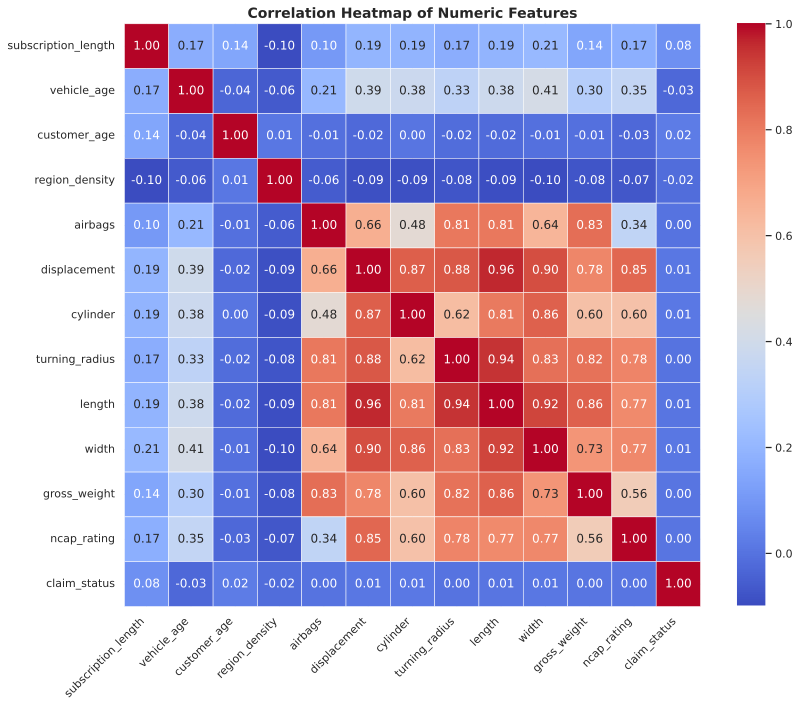

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("Insurance claims data.csv")

# Compute correlation matrix (numeric only)
corr_matrix = df.corr(numeric_only=True)

# Plot full heatmap with adjusted size
plt.figure(figsize=(12, 10))  # Reduced from 18x14 to 12x10
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Formatting
plt.title('Correlation Heatmap of Numeric Features', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


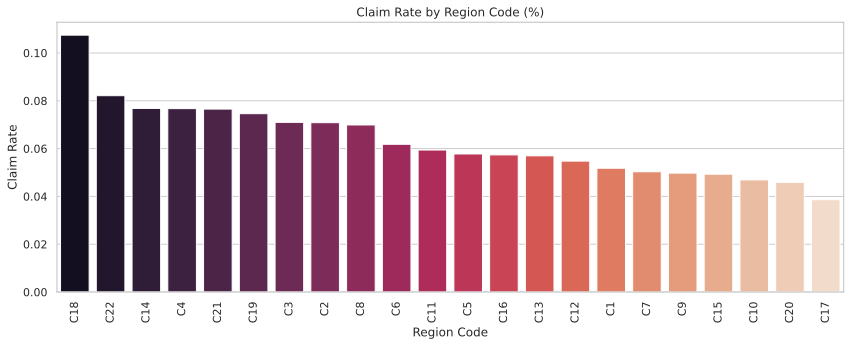

In [ ]:
# Calculate claim rate per region_code
claim_rate = df.groupby('region_code')['claim_status'].mean().sort_values(ascending=False)

# Plot the claim rate
plt.figure(figsize=(12, 5))
sns.barplot(x=claim_rate.index, y=claim_rate.values, palette='rocket')
plt.title('Claim Rate by Region Code (%)')
plt.ylabel('Claim Rate')
plt.xlabel('Region Code')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


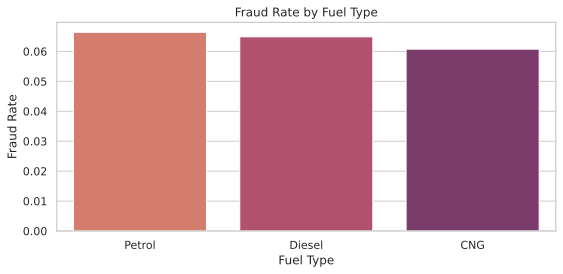

In [ ]:
plt.figure(figsize=(8, 4))
fuel_fraud = df.groupby('fuel_type')['claim_status'].mean().sort_values(ascending=False)
sns.barplot(x=fuel_fraud.index, y=fuel_fraud.values, palette="flare")
plt.title('Fraud Rate by Fuel Type')
plt.ylabel('Fraud Rate')
plt.xlabel('Fuel Type')
plt.tight_layout()
plt.show()


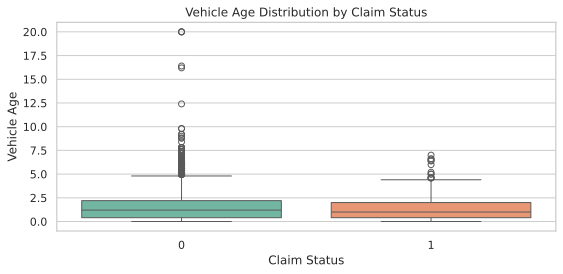

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='claim_status', y='vehicle_age', palette="Set2")
plt.title('Vehicle Age Distribution by Claim Status')
plt.xlabel('Claim Status')
plt.ylabel('Vehicle Age')
plt.tight_layout()
plt.show()


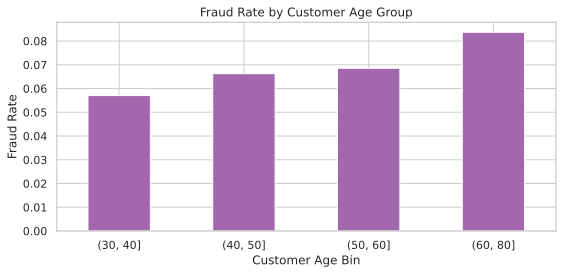

In [ ]:
df['customer_age_bin'] = pd.cut(df['customer_age'], bins=[30, 40, 50, 60, 80])
age_bin_fraud = df.groupby('customer_age_bin')['claim_status'].mean()

plt.figure(figsize=(8, 4))
age_bin_fraud.plot(kind='bar', color='#A267AC')
plt.title('Fraud Rate by Customer Age Group')
plt.ylabel('Fraud Rate')
plt.xlabel('Customer Age Bin')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


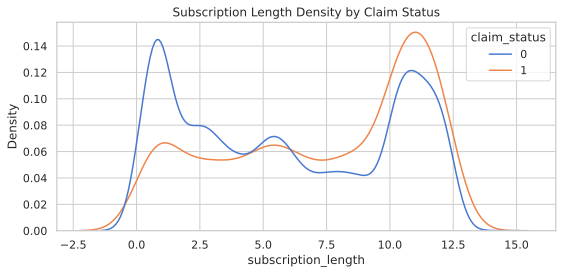

In [ ]:
df_clean = df[pd.to_numeric(df['subscription_length'], errors='coerce').notna()]
df_clean['subscription_length'] = df_clean['subscription_length'].astype(float)

plt.figure(figsize=(8, 4))
sns.kdeplot(data=df_clean, x='subscription_length', hue='claim_status', common_norm=False, palette='muted')
plt.title('Subscription Length Density by Claim Status')
plt.tight_layout()
plt.show()


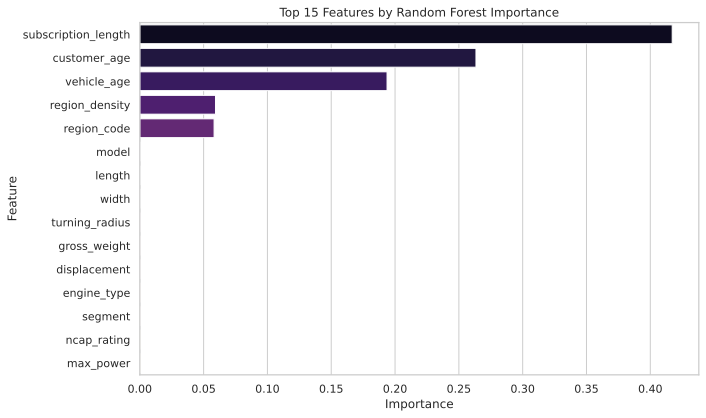

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Encode categorical variables
df = pd.read_csv("Insurance claims data.csv")
df_encoded = df.copy()
df_encoded.drop(columns='policy_id', axis=1, inplace=True)
cat_cols = df_encoded.select_dtypes(include='object').columns
for col in cat_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

# Drop interval features if present
df_encoded = df_encoded.drop(columns='customer_age_bin', errors='ignore')

# Prepare data
X = df_encoded.drop(columns='claim_status')
y = df_encoded['claim_status']

# Fit Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get importances
importances = rf.feature_importances_
features = X.columns

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='magma')
plt.title('Top 15 Features by Random Forest Importance')
plt.tight_layout()
plt.show()


# <a id='fifth'></a> Feature Engineering

In [ ]:

labenc = LabelEncoder()

# Apply LabelEncoder to each column if the column dtype is 'object', else keep the column as is
encoded_data = df.apply(lambda col: labenc.fit_transform(col) if col.dtype == 'object' else col)

In [ ]:
encoded_data.head()

,policy_id,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status
0,45359,9.3,1.2,41,20,8794,4,5,1,4,...,1,1,1,1,1,0,1,1,3,0
1,16744,8.2,1.8,35,11,27003,3,10,1,2,...,0,1,1,1,1,1,1,1,4,0
2,7193,9.5,0.2,44,20,8794,4,5,1,4,...,1,1,1,1,1,0,1,1,3,0
3,18145,5.2,0.4,44,1,73430,0,0,0,5,...,0,0,0,1,0,0,0,1,0,0
4,49010,10.1,1.0,56,4,5410,2,6,1,3,...,0,1,1,1,0,0,1,1,5,0


In [ ]:
import numpy as np
import pandas as pd



# 1. Age-related ratios
encoded_data["vehicle_to_customer_age_ratio"] = encoded_data["vehicle_age"] / (encoded_data["customer_age"] + 0.1)
encoded_data["subscription_per_vehicle_age"] = encoded_data["subscription_length"] / (encoded_data["vehicle_age"] + 0.1)

# 2. Log transformations for skewed variables
encoded_data["log_subscription_length"] = np.log1p(encoded_data["subscription_length"])
encoded_data["log_vehicle_age"] = np.log1p(encoded_data["vehicle_age"])
encoded_data["log_customer_age"] = np.log1p(encoded_data["customer_age"])

# 3. Interaction features
encoded_data["subscription_vehicle_interaction"] = encoded_data["subscription_length"] * encoded_data["vehicle_age"]
encoded_data["customer_subscription_interaction"] = encoded_data["customer_age"] * encoded_data["subscription_length"]

# 4. High-risk region flag (based on fraud rate > 10%)
region_claim_rate = encoded_data.groupby("region_code")["claim_status"].mean()
high_risk_regions = region_claim_rate[region_claim_rate > 0.10].index.tolist()
encoded_data["is_high_risk_region"] = encoded_data["region_code"].apply(lambda x: 1 if x in high_risk_regions else 0)

# 5. Total safety features (sum of binary is_ features)
safety_features = [col for col in encoded_data.columns if col.startswith("is_")]
encoded_data["total_safety_features"] = encoded_data[safety_features].sum(axis=1)




In [ ]:
# Separating features (X) and target variable (y)
X = encoded_data.drop('claim_status', axis=1)
y = encoded_data['claim_status']

In [ ]:
# Instantiate the Random Forest classifier with a random state of 42
rf_model = RandomForestClassifier(random_state=42)

# Fit the model to the training data
rf_model.fit(X, y)


RandomForestClassifier(random_state=42)

In [ ]:
# Get feature importances from the trained Random Forest model
feature_importance = rf_model.feature_importances_


In [ ]:
# Create a DataFrame to store feature names and their corresponding importances
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort the DataFrame by feature importance in descending order
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
features_df.head(10)

,Feature,Importance
0,policy_id,0.146819
46,customer_subscription_interaction,0.108669
41,subscription_per_vehicle_age,0.085151
45,subscription_vehicle_interaction,0.072970
40,vehicle_to_customer_age_ratio,0.072840
42,log_subscription_length,0.070782
1,subscription_length,0.070427
3,customer_age,0.066069
44,log_customer_age,0.064997
5,region_density,0.059161


#UnderSampling

In [ ]:
'''from sklearn.utils import resample

# Create subsets
minority = df[df['claim_status'] == 1]
majority = df[df['claim_status'] == 0]

# Undersample the majority class
majority_undersampled = resample(majority,
                                  replace=False,  # no replacement
                                  n_samples=len(minority),  # match minority count
                                  random_state=42)

# Combine to create a balanced dataset
undersampled_data = pd.concat([minority, majority_undersampled])

# Shuffle the result (optional but recommended)
oversampled_data = undersampled_data.sample(frac=1, random_state=42).reset_index(drop=True)'''


"from sklearn.utils import resample\n\n# Create subsets\nminority = df[df['claim_status'] == 1]\nmajority = df[df['claim_status'] == 0]\n\n# Undersample the majority class\nmajority_undersampled = resample(majority,\n                                  replace=False,  # no replacement\n                                  n_samples=len(minority),  # match minority count\n                                  random_state=42)\n\n# Combine to create a balanced dataset\nundersampled_data = pd.concat([minority, majority_undersampled])\n\n# Shuffle the result (optional but recommended)\noversampled_data = undersampled_data.sample(frac=1, random_state=42).reset_index(drop=True)"

# <a id='fourth'></a> OverSampling

In [ ]:

minority = df[df['claim_status'] == 1]
majority = df[df['claim_status'] == 0]
# Oversampling the minority class to balance the dataset
minority_oversampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
oversampled_data = pd.concat([majority, minority_oversampled])


In [ ]:

X_oversampled = oversampled_data.drop('claim_status', axis=1)
y_oversampled = oversampled_data['claim_status']


In [ ]:
# Apply LabelEncoder to each column if the column dtype is 'object', else keep the column as is
X_oversampled_encoded = X_oversampled.apply(lambda col: LabelEncoder().fit_transform(col) if col.dtype == 'object' else col)


# <a id='sixth'></a> Data Splitting

In [ ]:
# Splitting the oversampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_oversampled_encoded, y_oversampled, test_size=0.4, random_state=42)

# <a id='seventh'></a> Model Training

In [ ]:
# Instantiate the Random Forest classifier with a random state of 42
rf_model_oversampled = RandomForestClassifier(random_state=42)


rf_model_oversampled.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:

y_pred = rf_model_oversampled.predict(X_test)


In [ ]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     21994
           1       0.98      1.00      0.99     21882

    accuracy                           0.99     43876
   macro avg       0.99      0.99      0.99     43876
weighted avg       0.99      0.99      0.99     43876

